# `<Title>`

Authors:
- Carson Jan
- Ken Yang
- Xiaoheng Wang
- Yunle Xu

DSCI 100 003 <br>
Project Final Report <br>
Group 30

---
# Introduction
## Background infomation on the topic
The project focuses on data from a MineCraft research server set up by UBC Computer Science. The server records player actions, and the goal is to address practical challenges:

1. Player Recruitment: Identifying which types of players contribute the most data to target recruitment effectively.
2. Resource Allocation: Predicting player activity to manage server resources like hardware and licenses.

The main question is: “Which kinds of players are most likely to contribute a large amount of data?”

Using a Jupyter Notebook, the project will clean data, explore patterns, build predictive models, and document results for actionable insights.

## Posted question
We choose the first question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.


## Description of the dataset used
|variable Name|Type|Description|
|---|---|---|
|hashedEmail|character|A hashed version of the player’s email, used to anonymize player identity|
|start_time|character|The start time of the player’s session (needs to be converted to date-time format)|
|end_time|character|The end time of the player’s session (needs to be converted to date-time format)|
|original_start_time|numeric|The exact start time recorded as a timestamp|
|original_end_time|numeric|The exact end time recorded as a timestamp|

---
# Methods & Results
## Methods used
## Code

#### Libraries/ initialization

In [2]:
library(tidyverse)
library(tidymodels)
library(tidyclust)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Load data

In [3]:
players <- read_csv('data/players.csv')
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


#### Wrangle & Clean data

In [112]:
mapping_exp <- c("Beginner" = 1, "Amateur" = 2, "Regular" = 3,
                 "Pro" = 4, "Veteran" = 5)
mapping_gender <- c("Male" = 1, "Female" = 2, "Non-binary" = 3,
                 "Agender" = 4, "Two-Spirited" =5, "Other" = 6, "Prefer not to say"=7)

players_clean <- players |>
    mutate(experience2 = as.integer(mapping_exp[experience])) |>
    mutate(subscribe2 = as.integer(subscribe)) |>
    mutate(gender2=as.integer(mapping_gender[gender])) |>
    mutate(gender3=gender) |> mutate(value=1) |> #one hat encoding: this and next line
    pivot_wider(names_from=gender3, names_prefix='gender_', values_from=value, values_fill=0) |> 
    select(-hashedEmail, -name, -individualId, -organizationName) #rm data not important to Qs/NA

head(players_clean)


experience,subscribe,played_hours,gender,age,experience2,subscribe2,gender2,gender_Male,gender_Female,gender_Non-binary,gender_Prefer not to say,gender_Agender,gender_Two-Spirited,gender_Other
<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,TRUE,30.3,Male,9,4,1,1,1,0,0,0,0,0,0
Veteran,TRUE,3.8,Male,17,5,1,1,1,0,0,0,0,0,0
Veteran,FALSE,0.0,Male,17,5,0,1,1,0,0,0,0,0,0
Amateur,TRUE,0.7,Female,21,2,1,2,0,1,0,0,0,0,0
Regular,TRUE,0.1,Male,21,3,1,1,1,0,0,0,0,0,0
Amateur,TRUE,0.0,Female,17,2,1,2,0,1,0,0,0,0,0


In [ ]:
#### Summary of dataset
> exploratory data analysis related to the planned analysis 

#### Visualization of dataset 
> exploratory data analysis related to the planned analysis

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


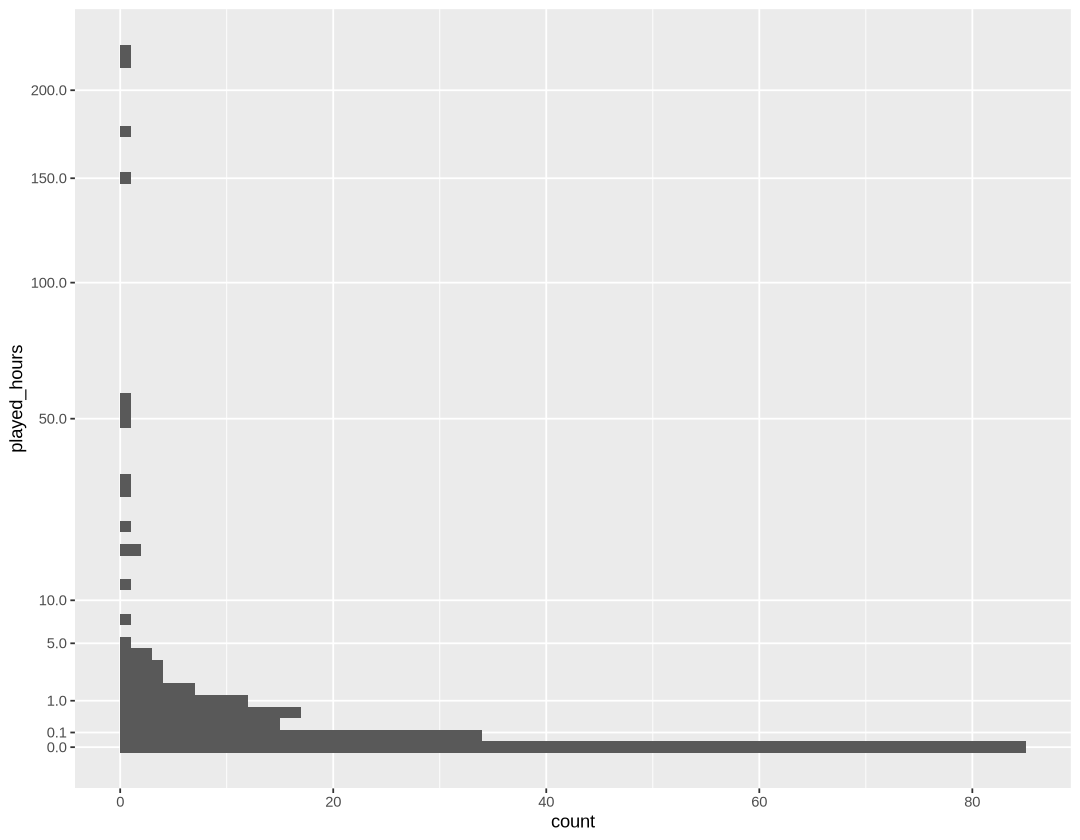

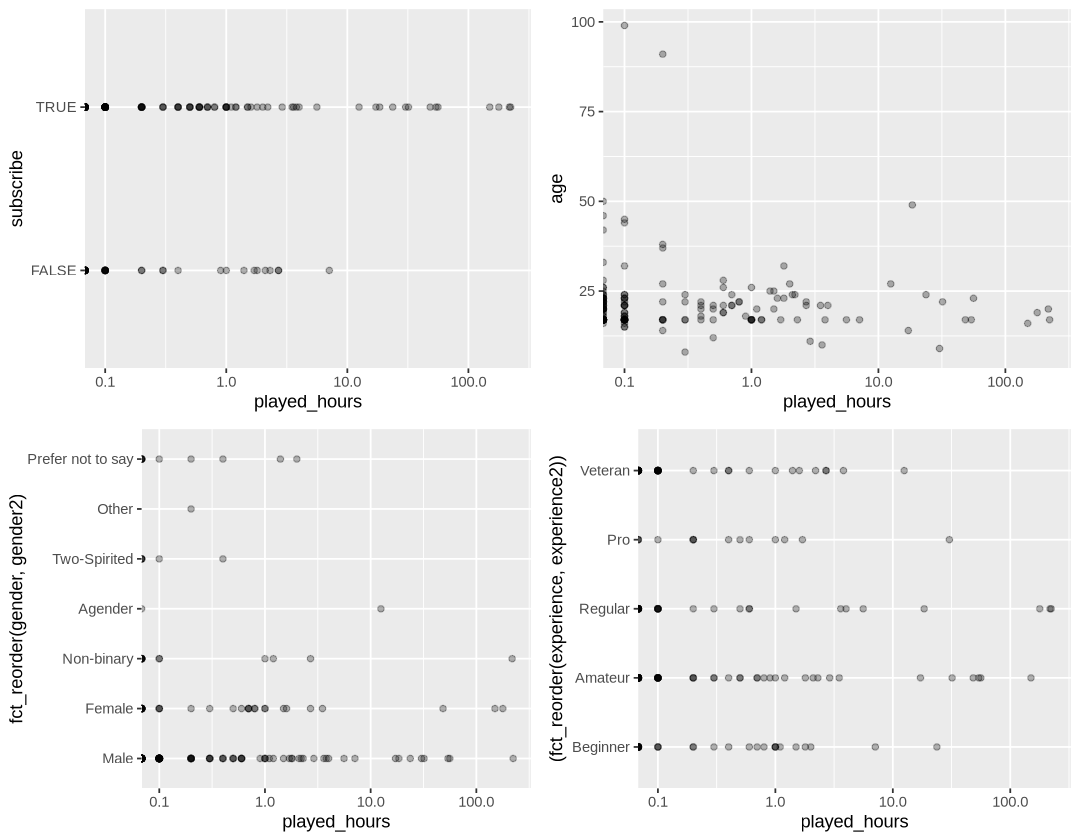

In [118]:
library(gridExtra)

h <- players_clean |>
    ggplot(aes(y=played_hours)) +
    geom_histogram(binwidth=0.25) +
        scale_y_sqrt(breaks = c(0, 0.1 , 1, 5, 10, 50, 100, 150, 200),
                    minor_breaks = NULL)
                    

a <- players_clean |>
    ggplot(aes(x=played_hours, y=age)) +
        geom_point(alpha=0.3) +
        scale_x_log10()


g <- players_clean |>
    ggplot(aes(x=played_hours, 
               y=fct_reorder(gender, gender2))) +
        geom_point(alpha=0.3) +
        scale_x_log10()

e <- players_clean |>
    ggplot(aes(x=played_hours, 
               y=(fct_reorder(experience, experience2)))) +
        geom_point(alpha=0.3) +
        scale_x_log10()

s <- players_clean |>
    ggplot(aes(x=played_hours, y=subscribe)) +
        geom_point(alpha=0.3) +
        scale_x_log10()

options(repr.plot.width=9)
h
grid.arrange(s, a, g, e, ncol=2)

#### Data analysis

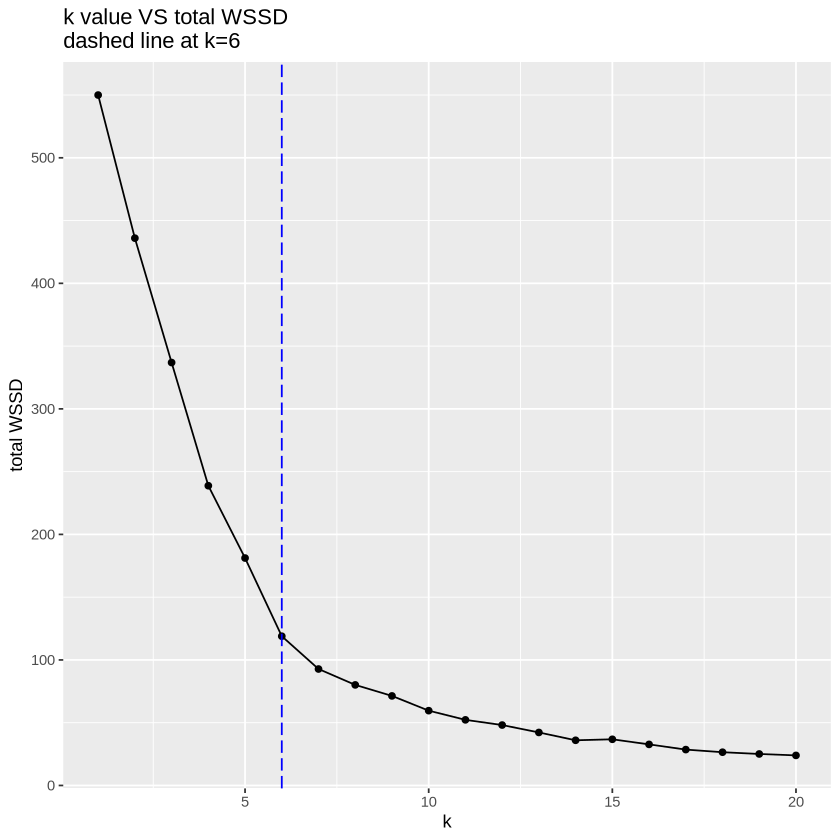

In [6]:
set.seed(2024)

recipe_players <- recipe(~ played_hours + age + experience2 + subscribe2 + gender2, 
                         data=players_mapped) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

ks <- tibble(num_clusters = seq(1,20,1))

players_spec_tune <- k_means(num_clusters = tune()) |>
    set_engine('stats', nstart=50)

players_tune <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec_tune)|>
    tune_cluster(apparent(players_mapped), grid=ks) |>
    collect_metrics() |>
    filter(.metric=='sse_within_total')

players_tune_plot <- players_tune |>
    ggplot(aes(x=num_clusters, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x='k', y='total WSSD', title='k value VS total WSSD\ndashed line at k=6') +
    geom_vline(xintercept = 6, color='blue', linetype = "longdash")

players_tune_plot

##### Choice of k value
Using the elbow method we choose k=6 for our model

.cluster,played_hours,age,experience2,subscribe2,gender2
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cluster_1,-0.2135775,-0.15806431,1.2571914,0.5367297,-0.1734364
Cluster_2,-0.1280058,-0.14531920,-0.6091877,0.5367297,-0.3028762
Cluster_3,-0.2491816,0.03705027,0.1845519,-1.8463502,-0.2788388
Cluster_4,-0.2577874,-0.09108468,-0.5195657,-0.2576303,3.3916446
Cluster_5,4.9019885,-0.33080125,-0.1117853,0.5367297,0.1973320
Cluster_6,-0.2739454,6.18384925,0.4125036,0.5367297,2.5930665


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 25 rows containing non-finite outside the scale range (`stat_bin()`).”


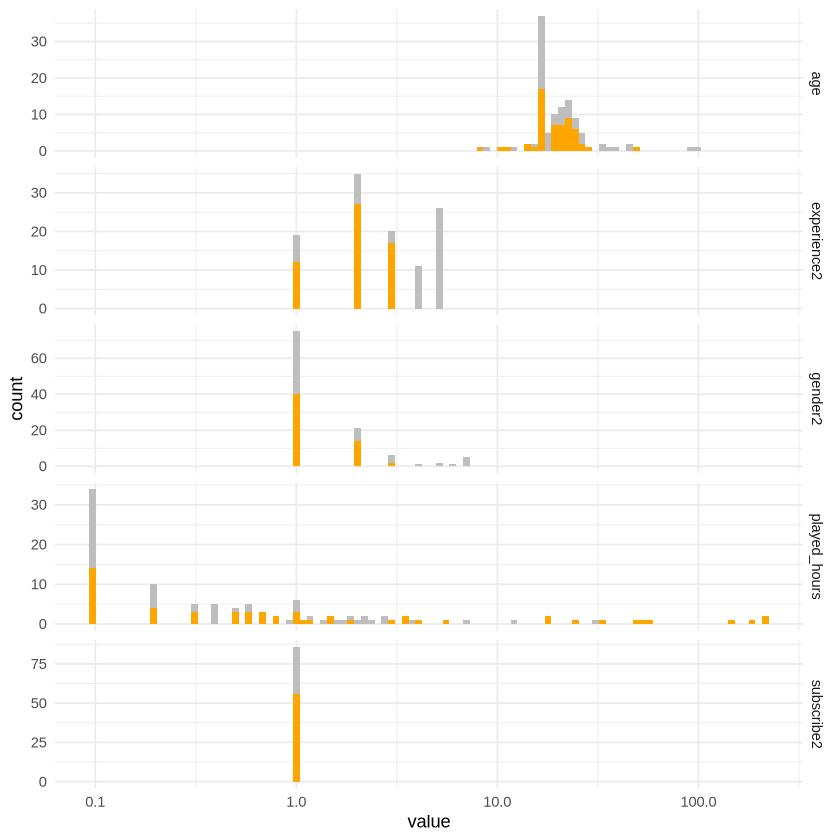

In [7]:
set.seed(2024)

players_spec <- k_means(num_clusters = 6) |>
    set_engine('stats', nstart=100)

players_fit <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec)|>
    fit(players_mapped)

players_fit |> 
    extract_centroids()

players_fit_df <- players_fit |>
    augment(players_mapped) |>
    select(-experience, -subscribe, -gender)

# players_fit_plot <- players_fit_df |>
#     ggplot(aes(x = played_hours, fill = .pred_cluster)) +
#           geom_histogram(bins=100) +
#           scale_x_log10()+
#           labs(title = "Cluster Highlighting",
#                x = "X Axis Label",
#                y = "Y Axis Label") +
#           theme_minimal()
# players_fit_plot

#####
players_fit_plot <- players_fit_df |>
    pivot_longer(cols=-.pred_cluster, names_to='category', values_to='value') |> 
    mutate(color = ifelse(.pred_cluster == "Cluster_5"|.pred_cluster == "Cluster_2", "orange", "grey")) |>
    ggplot(aes(x = value, fill = color)) +
          geom_histogram(bins=100) +
          # geom_density(alpha=0.4, color='white') +
          scale_fill_identity() +
          # scale_color_manual(values = c("TRUE" = "orange", "FALSE" = "grey")) +
          facet_grid(rows=vars(category), scales='free') +
          scale_x_log10()+
          # labs(title = "Cluster Highlighting",
          #      x = "X Axis Label",
          #      y = "Y Axis Label") +
          theme_minimal()
players_fit_plot

# 3    4.9019885 -0.33080125  -0.1117853  0.5367297  0.1973320
# players_max_t <- players_fit_df |>
#     filter(.pred_cluster == 'Cluster_3')
# players_max_t

#### Visualization
> note: all figures should have a figure number and a legend

---
# Discussion
## Summarization
## Is it what we expected to found?
## What impact could such findings have
## What future questions chould this lead to?

---
# References
> *note to group members: Use APA 7, please*

---
End of report <br>
Finalized and approved by all group member on `<date>`
> *note to group members: run report through grammar check, please*


To be uploaded by `<member>` by `<date>`